In [1]:
from huggingface_hub import notebook_login
# notebook_login()

In [2]:
import numpy as np 
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline, DDIMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


'cuda'

In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe = image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

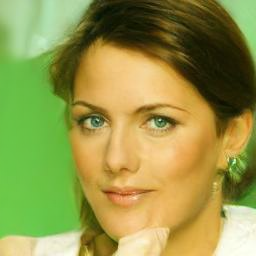

In [4]:
images = image_pipe().images
images[0]

In [5]:
scheduler: DDIMScheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


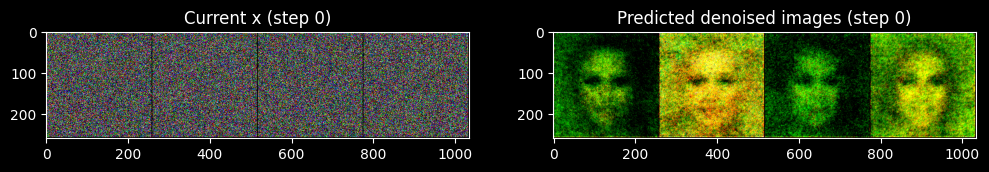

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


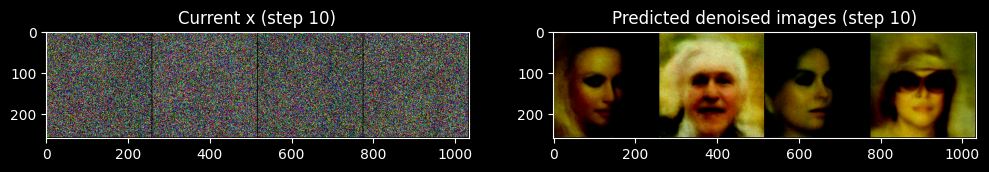

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


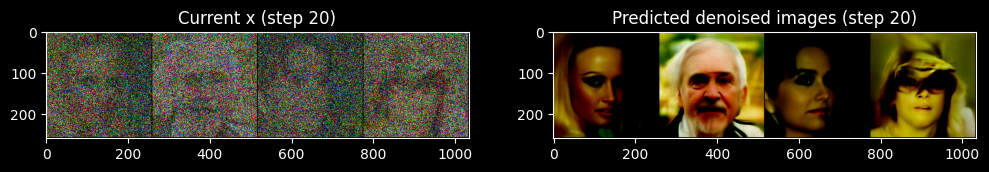

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


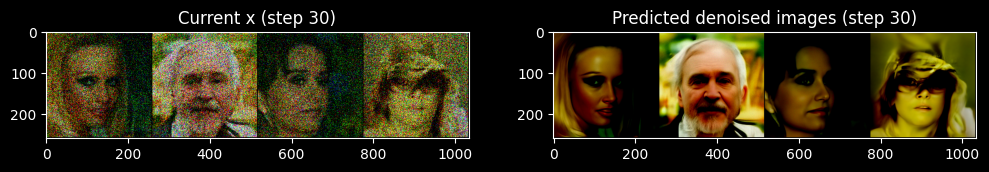

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


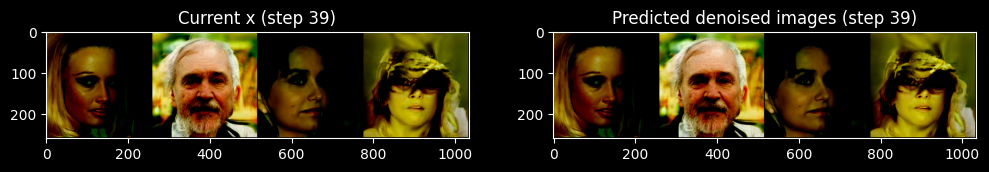

In [6]:
x: torch.Tensor = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    # noise
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        # pred next noise
        noise_pred = image_pipe.unet(model_input, t)['sample']
    # update next x
    scheduler_output = scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        grid = torchvision.utils.make_grid(x.cpu(), nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu())
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )
        grid = torchvision.utils.make_grid(pred_x0.cpu(), nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu())
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()


  0%|          | 0/40 [00:00<?, ?it/s]

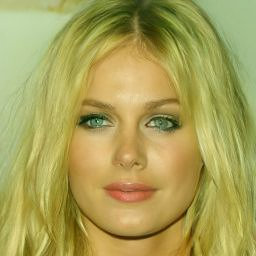

In [7]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [8]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name)
image_size = 256
batch_size = 1
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([.5], [.5]),
    ]
)


def transfrom(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transfrom)
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Previewing batch:


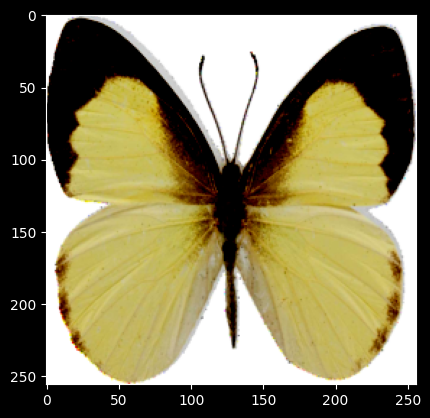

In [9]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [11]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2

opitimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        noise = torch.randn_like(clean_images).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(
            0, 
            image_pipe.scheduler.num_inference_steps,
            (bs,),
            device=clean_images.device,
        ).long()

        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()

        if (step + 1) % grad_accumulation_steps == 0:
            opitimizer.step()
            opitimizer.zero_grad()
    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}")
plt.plot(losses)
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # noise
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        # pred next noise
        noise_pred = image_pipe.unet(model_input, t)['sample']
    # update next x
    scheduler_output = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x.cpu(), nrow=4)
plt.imshow(grid.cpu())
plt.show()